In [1]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
from torchmodel import UNet
from root_dataset import Root_dataset
import albumentations as albu
import segmentation_models_pytorch as smp

/opt/homebrew/Caskroom/miniconda/base/envs/ptch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
def get_train_augmentation(height):
    trainaugmentation = albu.Compose([
        albu.Resize(height,height),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomRotate90(p=0.5),
        albu.Transpose(p=0.5),
        albu.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=15, p=0.5),
        albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        albu.GridDistortion(p=0.5),
        albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        albu.RandomBrightnessContrast(p=0.5),
        albu.RandomGamma(p=0.5),
        albu.GaussianBlur(blur_limit=(3, 7), p=0.5),
        albu.GaussNoise(),
        albu.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5), 
        #albu.Lambda(image=lambda x,**kwargs: x/255),
    ])
    return trainaugmentation

In [4]:
def get_val_augmentation(height):
    trainaugmentation = albu.Compose([
        albu.Resize(height,height),
        # albu.Lambda(image=lambda x,**kwargs: x/255),
    ])
    return trainaugmentation

In [5]:
train_aug = get_train_augmentation(512)
val_aug = get_val_augmentation(512)

In [6]:
train = Root_dataset(train_aug,'crosval/train','castom-masks/masks_machine',device)
val = Root_dataset(val_aug,'crosval/val','castom-masks/masks_machine',device)

['AAE_0196.png', 'AAE_0182.png', 'AAE_0021.png', 'AAE_0236.png', 'AAE_0140.png', 'AAE_0154.png', 'AAE_0181.png', 'AAE_0156.png', 'AAE_0036.png', 'AAE_0022.png', 'AAE_0209.png', 'AAE_0180.png', 'AAE_0184.png', 'AAE_0190.png', 'AAE_0147.png', 'AAE_0027.png', 'AAE_0218.png', 'AAE_0146.png', 'AAE_0185.png', 'AAE_0193.png', 'AAE_0150.png', 'AAE_0226.png', 'AAE_0233.png', 'AAE_0019.png', 'AAE_0025.png', 'AAE_0179.png', 'AAE_0145.png', 'AAE_0192.png', 'AAE_0136.png', 'AAE_0057.png', 'AAE_0080.png', 'AAE_0041.png', 'AAE_0040.png', 'AAE_0068.png', 'AAE_0083.png', 'AAE_0097.png', 'AAE_0124.png', 'AAE_0087.png', 'AAE_0045.png', 'AAE_0119.png', 'AAE_0125.png', 'AAE_0127.png', 'AAE_0047.png', 'AAE_0085.png', 'AAE_0117.png', 'AAE_0063.png', 'AAE_0076.png', 'AAE_0062.png', 'AAE_0089.png', 'AAE_0116.png', 'AAE_0100.png', 'AAE_0114.png', 'AAE_0048.png', 'AAE_0101.png', 'AAE_0071.png', 'AAE_0058.png', 'AAE_0070.png', 'AAE_0073.png', 'AAE_0098.png', 'AAE_0107.png', 'AAE_0174.png', 'AAE_0028.png', 'AAE_00

<Figure size 640x480 with 0 Axes>

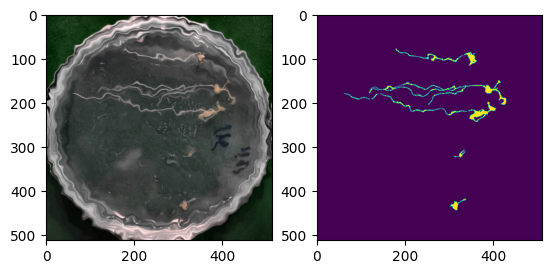

In [7]:
plt.figure()
f, axarr = plt.subplots(1,2) 
image,mask = train.__getitem__(0)
axarr[0].imshow(image.permute(1,2,0).cpu())
axarr[1].imshow(mask.permute(1,2,0).cpu())

In [8]:
model = UNet(3,1)

In [9]:
train_loader = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val, batch_size=4, shuffle=False, num_workers=2)

In [10]:
focalloss_f = smp.losses.FocalLoss('binary')
doceloss_f = smp.losses.DiceLoss('binary')
optimizer = torch.optim.Adam(model.parameters(),0.001,amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=2,verbose=True)

In [11]:
def loss_f(outputs, targets):
    focal = focalloss_f(outputs, targets)
    dice = doceloss_f(outputs,targets)
    loss = focal * 0.7 + dice * 0.3
    return loss

In [12]:
epochs = 100

In [13]:
model.to(device)
best_loss = 100
for epoch in range(epochs):
    train_loss = 0.0
    model.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_f(outputs,targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    val_loss = 0.0

    model.eval()
    for inputs, targets in tqdm(val_loader):
        model.eval()
        outputs = model(inputs)
            
            # Calculate loss
        loss = loss_f(outputs,targets)
        val_loss += loss.item()

    val_loss /= len(val_loader)

    scheduler.step(val_loss)

    if val_loss < best_loss: 
        best_loss = val_loss
        torch.save(model, 'best-model.pt')

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        

100%|██████████| 8/8 [00:15<00:00,  1.98s/it]


Epoch [1/100] | Train Loss: 0.5176 | Val Loss: 0.5302


100%|██████████| 8/8 [00:15<00:00,  1.98s/it]


Epoch [2/100] | Train Loss: 0.4913 | Val Loss: 0.4934


100%|██████████| 8/8 [00:15<00:00,  2.00s/it]


Epoch [3/100] | Train Loss: 0.4792 | Val Loss: 0.4739


100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


Epoch [4/100] | Train Loss: 0.4700 | Val Loss: 0.4648


100%|██████████| 8/8 [00:16<00:00,  2.01s/it]


Epoch [5/100] | Train Loss: 0.4631 | Val Loss: 0.4576


100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


Epoch [6/100] | Train Loss: 0.4571 | Val Loss: 0.4527


100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


Epoch [7/100] | Train Loss: 0.4520 | Val Loss: 0.4485


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [8/100] | Train Loss: 0.4477 | Val Loss: 0.4451


100%|██████████| 8/8 [00:15<00:00,  1.98s/it]


Epoch [9/100] | Train Loss: 0.4440 | Val Loss: 0.4412


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [10/100] | Train Loss: 0.4407 | Val Loss: 0.4378


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [11/100] | Train Loss: 0.4377 | Val Loss: 0.4346


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [12/100] | Train Loss: 0.4352 | Val Loss: 0.4321


100%|██████████| 8/8 [00:15<00:00,  1.99s/it]


Epoch [13/100] | Train Loss: 0.4333 | Val Loss: 0.4315


100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


Epoch [14/100] | Train Loss: 0.4314 | Val Loss: 0.4293


100%|██████████| 8/8 [00:15<00:00,  1.96s/it]


Epoch [15/100] | Train Loss: 0.4296 | Val Loss: 0.4278


100%|██████████| 8/8 [00:15<00:00,  1.92s/it]


Epoch [16/100] | Train Loss: 0.4280 | Val Loss: 0.4263


100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


Epoch [17/100] | Train Loss: 0.4269 | Val Loss: 0.4252


100%|██████████| 8/8 [00:15<00:00,  1.94s/it]


Epoch [18/100] | Train Loss: 0.4258 | Val Loss: 0.4254


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [19/100] | Train Loss: 0.4251 | Val Loss: 0.4235


100%|██████████| 8/8 [00:15<00:00,  1.92s/it]


Epoch [20/100] | Train Loss: 0.4242 | Val Loss: 0.4228


100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


Epoch [21/100] | Train Loss: 0.4235 | Val Loss: 0.4222


100%|██████████| 8/8 [00:15<00:00,  1.94s/it]


Epoch [22/100] | Train Loss: 0.4229 | Val Loss: 0.4215


100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


Epoch [23/100] | Train Loss: 0.4223 | Val Loss: 0.4209


100%|██████████| 8/8 [00:15<00:00,  2.00s/it]


Epoch [24/100] | Train Loss: 0.4219 | Val Loss: 0.4206


100%|██████████| 8/8 [00:15<00:00,  1.98s/it]


Epoch [25/100] | Train Loss: 0.4214 | Val Loss: 0.4202


100%|██████████| 8/8 [00:15<00:00,  1.94s/it]


Epoch [26/100] | Train Loss: 0.4210 | Val Loss: 0.4199


100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


Epoch [27/100] | Train Loss: 0.4207 | Val Loss: 0.4196


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [28/100] | Train Loss: 0.4203 | Val Loss: 0.4193


100%|██████████| 8/8 [00:15<00:00,  1.99s/it]


Epoch [29/100] | Train Loss: 0.4202 | Val Loss: 0.4191


100%|██████████| 8/8 [00:15<00:00,  1.98s/it]


Epoch [30/100] | Train Loss: 0.4198 | Val Loss: 0.4188


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [31/100] | Train Loss: 0.4197 | Val Loss: 0.4186


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [32/100] | Train Loss: 0.4195 | Val Loss: 0.4184


100%|██████████| 8/8 [00:15<00:00,  1.92s/it]


Epoch [33/100] | Train Loss: 0.4193 | Val Loss: 0.4182


100%|██████████| 8/8 [00:15<00:00,  1.94s/it]


Epoch [34/100] | Train Loss: 0.4192 | Val Loss: 0.4181


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [35/100] | Train Loss: 0.4189 | Val Loss: 0.4179


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [36/100] | Train Loss: 0.4188 | Val Loss: 0.4177


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [37/100] | Train Loss: 0.4187 | Val Loss: 0.4176


100%|██████████| 8/8 [00:15<00:00,  1.92s/it]


Epoch [38/100] | Train Loss: 0.4186 | Val Loss: 0.4175


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [39/100] | Train Loss: 0.4185 | Val Loss: 0.4174


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [40/100] | Train Loss: 0.4182 | Val Loss: 0.4173


100%|██████████| 8/8 [00:15<00:00,  1.96s/it]


Epoch [41/100] | Train Loss: 0.4183 | Val Loss: 0.4172


100%|██████████| 8/8 [00:15<00:00,  1.94s/it]


Epoch [42/100] | Train Loss: 0.4181 | Val Loss: 0.4171


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [43/100] | Train Loss: 0.4182 | Val Loss: 0.4170


100%|██████████| 8/8 [00:15<00:00,  1.92s/it]


Epoch [44/100] | Train Loss: 0.4180 | Val Loss: 0.4170


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [45/100] | Train Loss: 0.4181 | Val Loss: 0.4169


100%|██████████| 8/8 [00:15<00:00,  1.92s/it]


Epoch [46/100] | Train Loss: 0.4179 | Val Loss: 0.4169


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [47/100] | Train Loss: 0.4180 | Val Loss: 0.4168


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [48/100] | Train Loss: 0.4178 | Val Loss: 0.4168


100%|██████████| 8/8 [00:15<00:00,  1.94s/it]


Epoch [49/100] | Train Loss: 0.4178 | Val Loss: 0.4167


100%|██████████| 8/8 [00:15<00:00,  1.92s/it]


Epoch [50/100] | Train Loss: 0.4177 | Val Loss: 0.4167


100%|██████████| 8/8 [00:15<00:00,  1.92s/it]


Epoch [51/100] | Train Loss: 0.4176 | Val Loss: 0.4166


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [52/100] | Train Loss: 0.4176 | Val Loss: 0.4166


100%|██████████| 8/8 [00:15<00:00,  1.98s/it]


Epoch [53/100] | Train Loss: 0.4174 | Val Loss: 0.4166


100%|██████████| 8/8 [00:15<00:00,  1.96s/it]


Epoch [54/100] | Train Loss: 0.4175 | Val Loss: 0.4165


100%|██████████| 8/8 [00:15<00:00,  1.94s/it]


Epoch [55/100] | Train Loss: 0.4173 | Val Loss: 0.4165


100%|██████████| 8/8 [00:15<00:00,  1.94s/it]


Epoch [56/100] | Train Loss: 0.4174 | Val Loss: 0.4165


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [57/100] | Train Loss: 0.4174 | Val Loss: 0.4164


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [58/100] | Train Loss: 0.4173 | Val Loss: 0.4164


100%|██████████| 8/8 [00:15<00:00,  1.92s/it]


Epoch [59/100] | Train Loss: 0.4174 | Val Loss: 0.4164


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [60/100] | Train Loss: 0.4174 | Val Loss: 0.4163


100%|██████████| 8/8 [00:15<00:00,  1.94s/it]


Epoch [61/100] | Train Loss: 0.4172 | Val Loss: 0.4163


100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


Epoch [62/100] | Train Loss: 0.4174 | Val Loss: 0.4163


100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


Epoch [63/100] | Train Loss: 0.4173 | Val Loss: 0.4163


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [64/100] | Train Loss: 0.4170 | Val Loss: 0.4162


100%|██████████| 8/8 [00:16<00:00,  2.07s/it]


Epoch [65/100] | Train Loss: 0.4173 | Val Loss: 0.4162


100%|██████████| 8/8 [00:15<00:00,  1.99s/it]


Epoch [66/100] | Train Loss: 0.4173 | Val Loss: 0.4162


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [67/100] | Train Loss: 0.4171 | Val Loss: 0.4162


100%|██████████| 8/8 [00:15<00:00,  1.94s/it]


Epoch [68/100] | Train Loss: 0.4171 | Val Loss: 0.4162


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [69/100] | Train Loss: 0.4172 | Val Loss: 0.4162


100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


Epoch [70/100] | Train Loss: 0.4170 | Val Loss: 0.4161


100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


Epoch [71/100] | Train Loss: 0.4170 | Val Loss: 0.4161


100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


Epoch [72/100] | Train Loss: 0.4171 | Val Loss: 0.4161


100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


Epoch [73/100] | Train Loss: 0.4171 | Val Loss: 0.4161


100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


Epoch [74/100] | Train Loss: 0.4169 | Val Loss: 0.4161


100%|██████████| 8/8 [00:15<00:00,  1.94s/it]


Epoch [75/100] | Train Loss: 0.4170 | Val Loss: 0.4161


100%|██████████| 8/8 [00:15<00:00,  1.92s/it]


Epoch [76/100] | Train Loss: 0.4171 | Val Loss: 0.4161


100%|██████████| 8/8 [00:15<00:00,  1.92s/it]


Epoch [77/100] | Train Loss: 0.4169 | Val Loss: 0.4161


100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


Epoch [78/100] | Train Loss: 0.4171 | Val Loss: 0.4161


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [79/100] | Train Loss: 0.4171 | Val Loss: 0.4161


100%|██████████| 8/8 [00:15<00:00,  1.94s/it]


Epoch [80/100] | Train Loss: 0.4169 | Val Loss: 0.4161


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [81/100] | Train Loss: 0.4173 | Val Loss: 0.4161


100%|██████████| 8/8 [00:15<00:00,  1.94s/it]


Epoch [82/100] | Train Loss: 0.4170 | Val Loss: 0.4161


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch [83/100] | Train Loss: 0.4166 | Val Loss: 0.4161


100%|██████████| 8/8 [00:16<00:00,  2.06s/it]


Epoch [84/100] | Train Loss: 0.4170 | Val Loss: 0.4161


100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


Epoch [85/100] | Train Loss: 0.4169 | Val Loss: 0.4161


100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


Epoch [86/100] | Train Loss: 0.4172 | Val Loss: 0.4161


  0%|          | 0/8 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [14]:
model = torch.load('best-model.pt')

Epoch [10/10] | Train Loss: 4.1113 | Val Loss: 3.9804

In [15]:
outputs = 0
for inputs, targets in tqdm(val_loader):
    model.eval()
    outputs = model(inputs)

100%|██████████| 8/8 [00:16<00:00,  2.01s/it]


In [16]:
outputs.shape

torch.Size([3, 1, 512, 512])

In [17]:
outputs = outputs.reshape(3,1, 512, 512)

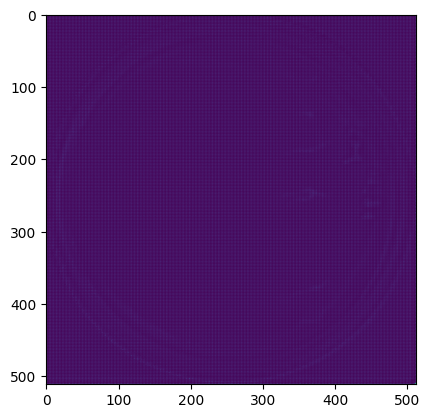

In [18]:
plt.imshow(outputs[0].permute(1,2,0).detach().numpy())